# Inference

This notebook shows how to load the __UNet-DeformSA__ and __TransDeformer__ model and their checkpoints from the repository and use them for inference with PyTorch. Evaluations of these two models' robustness with respect to the initial location of the template are shown as well. Also, the __ShapeErrorEstimate__ model and its checkpoint are also provided to estimate the errors of the input shape baased on the input image.
Throughout this notebook, lumbar spine geometry, shape, and contour are used interchangeably.

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage

In [2]:
import torch
from torch.utils.data import DataLoader

from models.backbone import UNetBackbone
from models.transDeformer import TransDeformer
from models.uNetDeformSA import UNetDeformSA
from models.shapeErrorEst import ShapeErrorEstimate

### Evaluation preparation
This section contains how to visualize the geometry of lumbar spine

In [3]:
def sort_lumbar_geometry():
    sorted_geometry = []
    cfgs = [
        "1 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 0 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 2 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 3 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171",
        "3 134 133 132 131 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 2 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 4 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 5 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242",
        "5 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192 191 190 189 4 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 6 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 7 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353",
        "7 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 301 300 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285 284 283 282 281 280 6 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 8 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 9 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424",
        "9 407 406 405 404 403 402 401 400 399 398 397 396 395 394 393 392 391 390 389 388 387 386 385 384 383 382 381 380 379 378 377 376 375 374 373 372 371 8 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 10 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 11 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535",
        "11 498 497 496 495 494 493 492 491 490 489 488 487 486 485 484 483 482 481 480 479 478 477 476 475 474 473 472 471 470 469 468 467 466 465 464 463 462 10 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 12 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 13 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606",
        "13 589 588 587 586 585 584 583 582 581 580 579 578 577 576 575 574 573 572 571 570 569 568 567 566 565 564 563 562 561 560 559 558 557 556 555 554 553 12 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 14 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 15 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717",
        "15 680 679 678 677 676 675 674 673 672 671 670 669 668 667 666 665 664 663 662 661 660 659 658 657 656 655 654 653 652 651 650 649 648 647 646 645 644 14 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 16 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 17 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788",
        "17 771 770 769 768 767 766 765 764 763 762 761 760 759 758 757 756 755 754 753 752 751 750 749 748 747 746 745 744 743 742 741 740 739 738 737 736 735 16 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 18 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 19 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899",
        "19 862 861 860 859 858 857 856 855 854 853 852 851 850 849 848 847 846 845 844 843 842 841 840 839 838 837 836 835 834 833 832 831 830 829 828 827 826 18 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 20 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 21 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970",
        "21 953 952 951 950 949 948 947 946 945 944 943 942 941 940 939 938 937 936 935 934 933 932 931 930 929 928 927 926 925 924 923 922 921 920 919 918 917 20 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 1001 1002 1003 1004 1005 1006 1007 22 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 23 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081"
    ]
    for idx, cfg in enumerate(cfgs):
        int_list = [int(str_idx) for str_idx in cfg.rstrip().split(' ')]
        if idx % 2 == 0:
            if idx != 10:
                sorted_geometry.append(int_list[0: 76] + int_list[114: ])
            else:
                sorted_geometry.append(int_list)
        else:
            sorted_geometry.append(int_list[0: 56] + int_list[94: ])
    return sorted_geometry
    
def visualize_geometry(shape, markersize, ax):
    sorted_geometry = sort_lumbar_geometry()
    base_colormap = plt.colormaps.get_cmap('jet')
    colors = base_colormap(np.linspace(0, 1, len(sorted_geometry)))
    colors = colors[::-1, :]
    for clr, cfg in zip(colors, sorted_geometry):
        ax.plot(shape[cfg, 0], shape[cfg, 1], '.', markersize=markersize, color=clr)

### Toy dataset preparation

In [4]:
class ToyDataSample(torch.utils.data.Dataset):
    def __init__(self):
        data = torch.load("./toy_dataset/demo.pt")
        self.img = data['image']
        self.img = self.img.reshape(1, self.img.shape[0], self.img.shape[1]).astype(np.float32)
        
        self.seg_label = data['label'].astype(np.int64)
        self.seg_mask = np.zeros((12, self.seg_label.shape[0], self.seg_label.shape[1]), dtype=np.float32)
        for idx in range(12):
            self.seg_mask[idx] = (self.seg_label == idx)
       
        self.shape_label = data['shape_sampled_39_19'].astype(np.float32)
    def __len__(self):
        return 1
    def __getitem__(self, index):
        return self.img, self.seg_label, self.seg_mask, self.shape_label

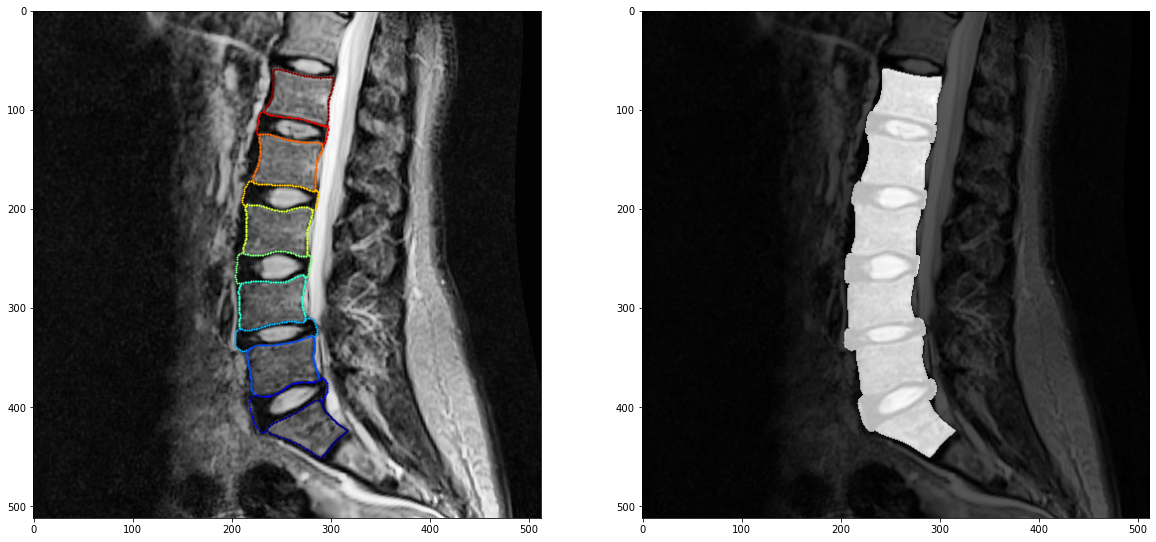

In [5]:
toy_dataset = ToyDataSample()
toy_img, toy_seg_label, toy_seg_mask, toy_shape_label = toy_dataset[0]
toy_img_shown = skimage.exposure.equalize_adapthist(toy_img[0], 128)

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(toy_img_shown, cmap='gray')
visualize_geometry(shape=toy_shape_label, markersize=2, ax=ax[0])
ax[1].imshow(toy_img_shown * 0.5 + toy_seg_mask[1:].sum(axis=0), cmap='gray')

### Common preparation

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
template = torch.tensor(data=torch.load('./toy_dataset/template.pt', map_location='cpu')['shape'], dtype=torch.float32)
template = template.view(1, -1, 2)
toy_dataloader = DataLoader(toy_dataset, batch_size=1, shuffle=False, pin_memory=True)

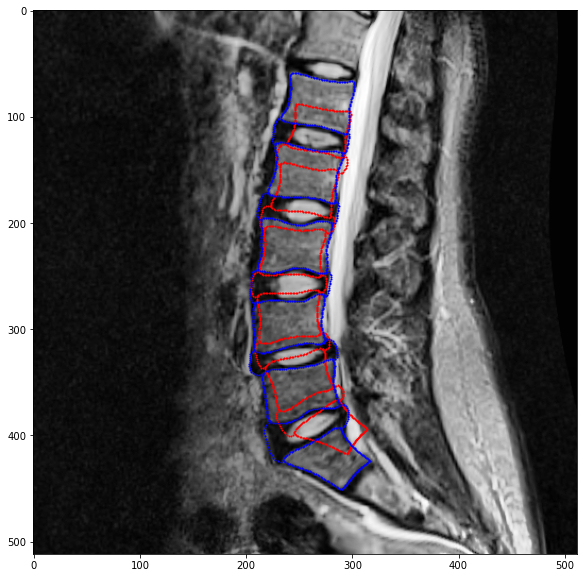

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(toy_img_shown, cmap='gray')
ax.plot(template[0, :, 0], template[0, :, 1], 'r.', markersize=2)
ax.plot(toy_shape_label[:, 0], toy_shape_label[:, 1], 'b.', markersize=2)

In the above figure, the red mesh/contour is the orignal template, and the blue one is the deformed template.

### UNet-DeformSA
This section contains how to initialize the __UNet-DeformSA__ model and load the saved checkpoint. Also, the inference (geometry reconstruction) and the evaluation on robustness with respect to the template's position are provided.

In [8]:
# Load backbone checkpoint
backbone = UNetBackbone(num_classes=12)
backbone.load_state_dict(torch.load("./checkpoints/backbone_checkpoint_file.pt", map_location='cpu')['model_state_dict'])    
backbone.eval()
# Load UNet-DeformSA checkpoint
udsa_args = {
    'n_layers'  : 2,
    'n_heads'   : 16,
    'embed_dim' : 512,
    'alpha'     : 100,
    'attn_drop' : 0,
    'C_in_high' : 32,
    'C_in_mid'  : 128,
    'C_in_low'  : 512,
    'beta'      : 1
}
udsa_model = UNetDeformSA(arg=udsa_args)
udsa_state = torch.load('./checkpoints/uNetDeformSA_checkpoint_file.pt', map_location='cpu')
udsa_model.load_state_dict(udsa_state['model_state_dict'])
udsa_model.eval()

UNetDeformSA(
  (shape_embedding0): ObjectShapeEmbedding(
    (pos): TemplateShapeEmbedding(
      (pos): Sequential(
        (0): Sin()
        (1): Sin()
        (2): Sin()
        (3): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (proj): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (shape_self_attn0): ModuleList(
    (0-1): 2 x ShapeSelfAttentionLayer(
      (MHA): Attention(
        (P): PositionEncoder()
        (Q): QueryEncoder(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp1): Linear(in_features=512, out_features=512, bias=True)
          (mlp2): Linear(in_features=512, out_features=512, bias=True)
        )
        (K): KeyEncoder(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp1): Linear(in_features=512,

In [9]:
toy_img_torch = torch.tensor(toy_img, dtype=torch.float32).view(1, 1, 512, 512)
toy_shape_label_torch = torch.tensor(toy_shape_label, dtype=torch.float32).view(1, -1, 2)

with torch.no_grad():
    _, backbone_features = backbone(toy_img_torch)
feature512 = backbone_features[0]
feature128 = backbone_features[1]
feature32 = backbone_features[2]
print({"feature512": feature512.shape, "feature128": feature128.shape, "feature32": feature32.shape})

{'feature512': torch.Size([1, 32, 512, 512]), 'feature128': torch.Size([1, 128, 128, 128]), 'feature32': torch.Size([1, 512, 32, 32])}


In [10]:
with torch.no_grad():
    # stage 0
    obj_pred_0 = template
    for n_iter in range(0, 1):
        obj0, obj1, obj2 = udsa_model(obj_pred_0, template, feature512, feature128, feature32)
        u_pred_0 = (obj2 - obj_pred_0).mean(dim=1, keepdim=True)
        obj_pred_0 = obj_pred_0 + u_pred_0            
    # stage 1
    obj_pred_1 = obj_pred_0
    for n_iter in range(0, 1):
        obj0, obj1, obj2 = udsa_model(obj_pred_1, template, feature512, feature128, feature32)
        obj_pred_1 = obj2
    # stage 2
    obj_pred_2 = obj_pred_1
    for n_iter in range(0, 0):
        obj0, obj1, obj2 = udsa_model(obj_pred_2, template, feature512, feature128, feature32)
        obj_pred_2 = obj2
assert (obj_pred_2 == obj_pred_1).all()
shape_pred_torch = obj_pred_2
shape_preds_torch = [obj_pred_0, obj_pred_1]

shape_pred_torch

tensor([[[242.4215,  57.1806],
         [302.1167,  66.4545],
         [232.8795, 101.9319],
         ...,
         [290.7039, 392.1622],
         [290.1549, 391.0634],
         [289.4669, 389.9399]]])

In [11]:
assert toy_shape_label_torch.shape == shape_pred_torch.shape == (1, 1082, 2)
ppd_error = ((shape_pred_torch - toy_shape_label_torch)**2).sum(dim=-1).sqrt()
ppd_errors = [((tmp - toy_shape_label_torch)**2).sum(dim=-1).sqrt() for tmp in shape_preds_torch]

ppd_error

tensor([[1.4452, 0.9932, 0.3680,  ..., 2.5641, 2.6675, 3.1575]])

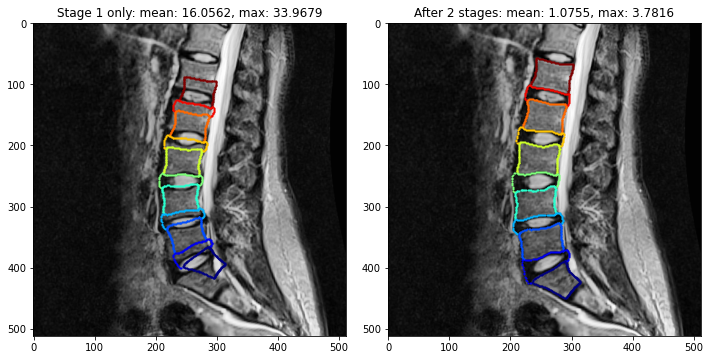

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout()
ax[0].imshow(toy_img_shown, cmap='gray')
ax[1].imshow(toy_img_shown, cmap='gray')
visualize_geometry(shape=shape_preds_torch[0][0], markersize=2, ax=ax[0])
visualize_geometry(shape=shape_preds_torch[1][0], markersize=2, ax=ax[1])

ax[0].set_title("Stage 1 only: mean: {:.4f}, max: {:.4f}".format(ppd_errors[0].cpu().numpy().mean(), ppd_errors[0].cpu().numpy().max()));
ax[1].set_title("After 2 stages: mean: {:.4f}, max: {:.4f}".format(ppd_errors[1].cpu().numpy().mean(), ppd_errors[1].cpu().numpy().max()));

In [13]:
rng = np.random.RandomState(seed=0)
for radius in [0, 10, 20, 30, 40]:
    theta = 2 * np.pi * rng.rand(1, 1, 1)
    noise_x = radius * np.cos(theta)
    noise_y = radius * np.sin(theta)
    noise = np.concatenate([noise_x, noise_y], axis=2)
    noise = torch.tensor(noise, dtype=template.dtype)

    with torch.no_grad():
        # stage 0
        obj_pred_0 = template + noise
        for n_iter in range(0, 1):
            obj0, obj1, obj2 = udsa_model(obj_pred_0, template, feature512, feature128, feature32)
            u_pred_0 = (obj2 - obj_pred_0).mean(dim=1, keepdim=True)
            obj_pred_0 = obj_pred_0 + u_pred_0            
        # stage 1
        obj_pred_1 = obj_pred_0
        for n_iter in range(0, 1):
            obj0, obj1, obj2 = udsa_model(obj_pred_1, template, feature512, feature128, feature32)
            obj_pred_1 = obj2
        # stage 2
        obj_pred_2 = obj_pred_1
        for n_iter in range(0, 0):
            obj0, obj1, obj2 = udsa_model(obj_pred_2, template, feature512, feature128, feature32)
            obj_pred_2 = obj2
    shape_pred_tmp = obj_pred_2
    
    ppd_error = ((shape_pred_tmp - toy_shape_label_torch)**2).sum(dim=-1).sqrt()
    print("Radius {}: mean: {:.4f}, max: {:.4f}".format(radius, ppd_error.cpu().numpy().mean(), ppd_error.cpu().numpy().max()))
    

Radius 0: mean: 1.0755, max: 3.7816
Radius 10: mean: 1.0753, max: 3.7812
Radius 20: mean: 1.0755, max: 3.7809
Radius 30: mean: 1.0755, max: 3.7807
Radius 40: mean: 1.0758, max: 3.7813


### TransDeformer
This section contains how to initialize the __TransDeformer__ model and load the saved checkpoint. Also, the inference (geometry reconstruction) and the evaluation on robustness with respect to the template's position are provided.

In [14]:
# Load TransDeformer checkpoint
tdfr_args = {
    'patch_size': [4, 4],
    'n_layers'  : 2,
    'n_heads'   : 16,
    'embed_dim' : 512,
    'alpha'     : 100,
    'attn_drop' : 0,
}
tdfr_model = TransDeformer(arg=tdfr_args)
tdfr_state = torch.load('./checkpoints/transDeformer_checkpoint_file.pt', map_location='cpu')
tdfr_model.load_state_dict(tdfr_state['model_state_dict'])
tdfr_model.eval()

TransDeformer(
  (image_feature): ImageFeatureLayer(
    (layer0): CNNBlock(
      (norm): SpatialContrastNorm()
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): GroupNorm(1, 64, eps=1e-05, affine=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): GroupNorm(1, 64, eps=1e-05, affine=False)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res_path): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (layer1): CNNBlock(
      (norm): SpatialContrastNorm()
      (conv): Sequential(
        (0): Conv2d(32, 256, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
        (1): GroupNorm(1, 256, eps=1e-05, affine=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(256, 256, kernel_s

In [15]:
toy_img_torch = torch.tensor(toy_img, dtype=torch.float32).view(1, 1, 512, 512)
toy_shape_label_torch = torch.tensor(toy_shape_label, dtype=torch.float32).view(1, -1, 2)

In [16]:
with torch.no_grad():
    # stage 0
    obj_pred_0 = template
    for n_iter in range(0, 1):
        obj0, obj1 = tdfr_model(obj_pred_0, template, toy_img_torch)
        u_pred_0 = (obj1 - obj_pred_0).mean(dim=1, keepdim=True)
        obj_pred_0 = obj_pred_0 + u_pred_0            
    # stage 1
    obj_pred_1 = obj_pred_0
    for n_iter in range(0, 1):
        obj0, obj1 = tdfr_model(obj_pred_1, template, toy_img_torch)
        obj_pred_1 = obj1
    # stage 2
    obj_pred_2 = obj_pred_1
    for n_iter in range(0, 0):
        obj0, obj1 = tdfr_model(obj_pred_2, template, toy_img_torch)
        obj_pred_2 = obj1
assert (obj_pred_2 == obj_pred_1).all()
shape_pred_torch = obj_pred_2
shape_preds_torch = [obj_pred_0, obj_pred_1]

shape_pred_torch

tensor([[[242.2240,  57.2200],
         [302.5834,  66.1185],
         [233.7428, 102.3282],
         ...,
         [290.2816, 392.7371],
         [289.5214, 391.4000],
         [288.7287, 390.5120]]])

In [17]:
assert toy_shape_label_torch.shape == shape_pred_torch.shape == (1, 1082, 2)
ppd_error = ((shape_pred_torch - toy_shape_label_torch)**2).sum(dim=-1).sqrt()
ppd_errors = [((tmp - toy_shape_label_torch)**2).sum(dim=-1).sqrt() for tmp in shape_preds_torch]

ppd_error

tensor([[1.4563, 1.5535, 1.3162,  ..., 1.8772, 2.1627, 2.3829]])

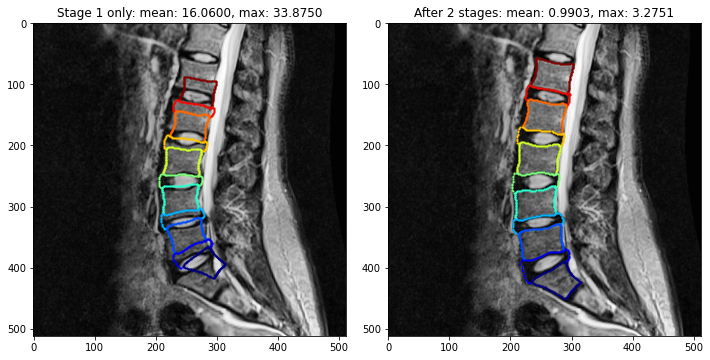

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout()
ax[0].imshow(toy_img_shown, cmap='gray')
ax[1].imshow(toy_img_shown, cmap='gray')
visualize_geometry(shape=shape_preds_torch[0][0], markersize=2, ax=ax[0])
visualize_geometry(shape=shape_preds_torch[1][0], markersize=2, ax=ax[1])

ax[0].set_title("Stage 1 only: mean: {:.4f}, max: {:.4f}".format(ppd_errors[0].cpu().numpy().mean(), ppd_errors[0].cpu().numpy().max()));
ax[1].set_title("After 2 stages: mean: {:.4f}, max: {:.4f}".format(ppd_errors[1].cpu().numpy().mean(), ppd_errors[1].cpu().numpy().max()));

In [19]:
rng = np.random.RandomState(seed=0)
for radius in [0, 10, 20, 30, 40]:
    theta = 2 * np.pi * rng.rand(1, 1, 1)
    noise_x = radius * np.cos(theta)
    noise_y = radius * np.sin(theta)
    noise = np.concatenate([noise_x, noise_y], axis=2)
    noise = torch.tensor(noise, dtype=template.dtype)

    with torch.no_grad():
        # stage 0
        obj_pred_0 = template + noise
        for n_iter in range(0, 1):
            obj0, obj1 = tdfr_model(obj_pred_0, template, toy_img_torch)
            u_pred_0 = (obj1 - obj_pred_0).mean(dim=1, keepdim=True)
            obj_pred_0 = obj_pred_0 + u_pred_0            
        # stage 1
        obj_pred_1 = obj_pred_0
        for n_iter in range(0, 1):
            obj0, obj1 = tdfr_model(obj_pred_1, template, toy_img_torch)
            obj_pred_1 = obj1
        # stage 2
        obj_pred_2 = obj_pred_1
        for n_iter in range(0, 0):
            obj0, obj1 = tdfr_model(obj_pred_2, template, toy_img_torch)
            obj_pred_2 = obj1
    shape_pred_tmp = obj_pred_2
    
    ppd_error = ((shape_pred_tmp - toy_shape_label_torch)**2).sum(dim=-1).sqrt()
    print("Radius {}: mean: {:.4f}, max: {:.4f}".format(radius, ppd_error.cpu().numpy().mean(), ppd_error.cpu().numpy().max()))
    

Radius 0: mean: 0.9903, max: 3.2751
Radius 10: mean: 0.9902, max: 3.2733
Radius 20: mean: 0.9902, max: 3.2738
Radius 30: mean: 0.9905, max: 3.2734
Radius 40: mean: 0.9899, max: 3.2771


### Shape Error Estimation
This section contains how to initialize the __ShapeErrorEstimate__ model and load the saved checkpoint. Given the input image and input shape, this model will estimate the distance error on each point of the input shape. Comparsion between the estimated error and true error is shown below.

In [20]:
sest_args = {
    'patch_size': [4, 4],
     'n_layers'  : 2,
     'n_heads'   : 16,
     'embed_dim' : 512,
     'alpha'     : 100,
     'attn_drop' : 0,
     'C_in'      : 128,
     'H_in'      : 128,
     'W_in'      : 128,
     'beta'      : 1
}
sest_model = ShapeErrorEstimate(arg=sest_args)
sest_state = torch.load('./checkpoints/shapeErrorEst_checkpoint_file.pt', map_location='cpu')
sest_model.load_state_dict(sest_state['model_state_dict'])
sest_model.eval()

ShapeErrorEstimate(
  (image_feature): ImageFeatureLayer(
    (layer0): CNNBlock(
      (norm): SpatialContrastNorm()
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): GroupNorm(1, 64, eps=1e-05, affine=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): GroupNorm(1, 64, eps=1e-05, affine=False)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res_path): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (layer1): CNNBlock(
      (norm): SpatialContrastNorm()
      (conv): Sequential(
        (0): Conv2d(32, 256, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
        (1): GroupNorm(1, 256, eps=1e-05, affine=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(256, 256, ker

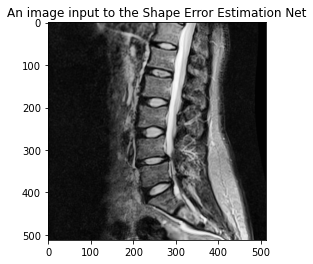

In [21]:
toy_img_torch = torch.tensor(toy_img, dtype=torch.float32).view(1, 1, 512, 512)
fig, ax = plt.subplots()
ax.imshow(toy_img_shown, cmap='gray')
ax.set_title('An image input to the Shape Error Estimation Net');

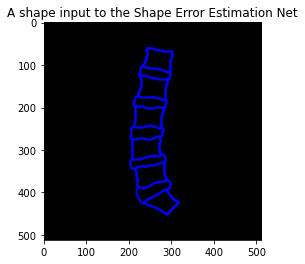

In [22]:
input_shape_error_est = template
fig, ax = plt.subplots()
ax.plot(toy_shape_label[:,0], toy_shape_label[:,1], 'b.', markersize=2)
ax.imshow(np.ones((512, 512)), cmap='gray')
ax.set_title('A shape input to the Shape Error Estimation Net');
ax.set_aspect(1)

In [23]:
error_pred = sest_model(input_shape_error_est, template, toy_img_torch)
error_pred

tensor([[30.7307, 28.2825, 23.9514,  ..., 24.4066, 24.2330, 24.0205]],
       grad_fn=<ViewBackward0>)

In [24]:
error_true = ((input_shape_error_est - toy_shape_label_torch)**2).sum(dim=-1).sqrt()
error_true

tensor([[29.3850, 27.9751, 25.7817,  ..., 26.5884, 26.2805, 26.1314]])

In [25]:
def error_est_plot(img_input, shape_input, error_input, ax):
    error_np = error_input.cpu().detach().numpy()[0]
    ax.imshow(img_input, cmap='gray', alpha=1)
    scatter = ax.scatter(shape_input[0, :, 0], shape_input[0, :, 1], c=error_np,
                         cmap='jet',
                         s=3, 
                         vmin=np.min(error_np), 
                         vmax=np.max(error_np))

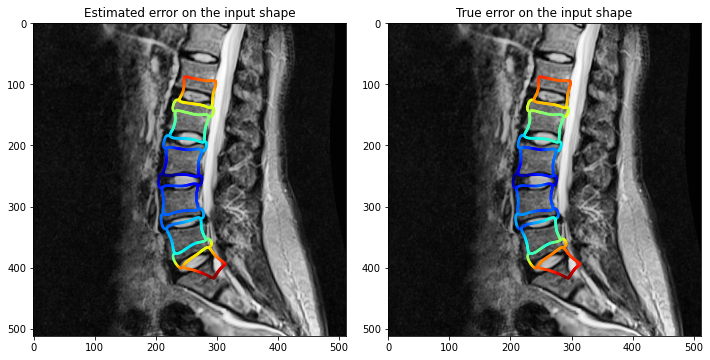

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
fig.tight_layout()
error_est_plot(toy_img_shown, input_shape_error_est, error_pred, ax[0])
error_est_plot(toy_img_shown, input_shape_error_est, error_true, ax[1])
ax[0].set_title('Estimated error on the input shape')
ax[1].set_title('True error on the input shape');